In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import timedelta

In [14]:
#Loading the datasets
sofr_data = pd.read_excel("SOFR.xlsx")
tsla_data = pd.read_excel("TSLA_AAPL_close.xlsx", sheet_name='TSLA')
sofr_data.head(), tsla_data.head()

(  observation_date  SOFR
 0       2018-04-03  1.83
 1       2018-04-04  1.74
 2       2018-04-05  1.75
 3       2018-04-06  1.75
 4       2018-04-09  1.75,
     fsym_id     p_date currency  p_price  p_price_open  p_price_high  \
 0  Q2YN1N-R 2010-06-29      USD    23.89         19.00       25.0000   
 1  Q2YN1N-R 2010-06-30      USD    23.83         25.79       30.4192   
 2  Q2YN1N-R 2010-07-01      USD    21.96         25.00       25.9200   
 3  Q2YN1N-R 2010-07-02      USD    19.20         23.00       23.1000   
 4  Q2YN1N-R 2010-07-05      USD    19.20         23.00       23.1000   
 
    p_price_low   p_volume  
 0        17.54  18783.279  
 1        23.30  17194.393  
 2        20.27   8229.862  
 3        18.71   5141.807  
 4        18.71      0.000  )

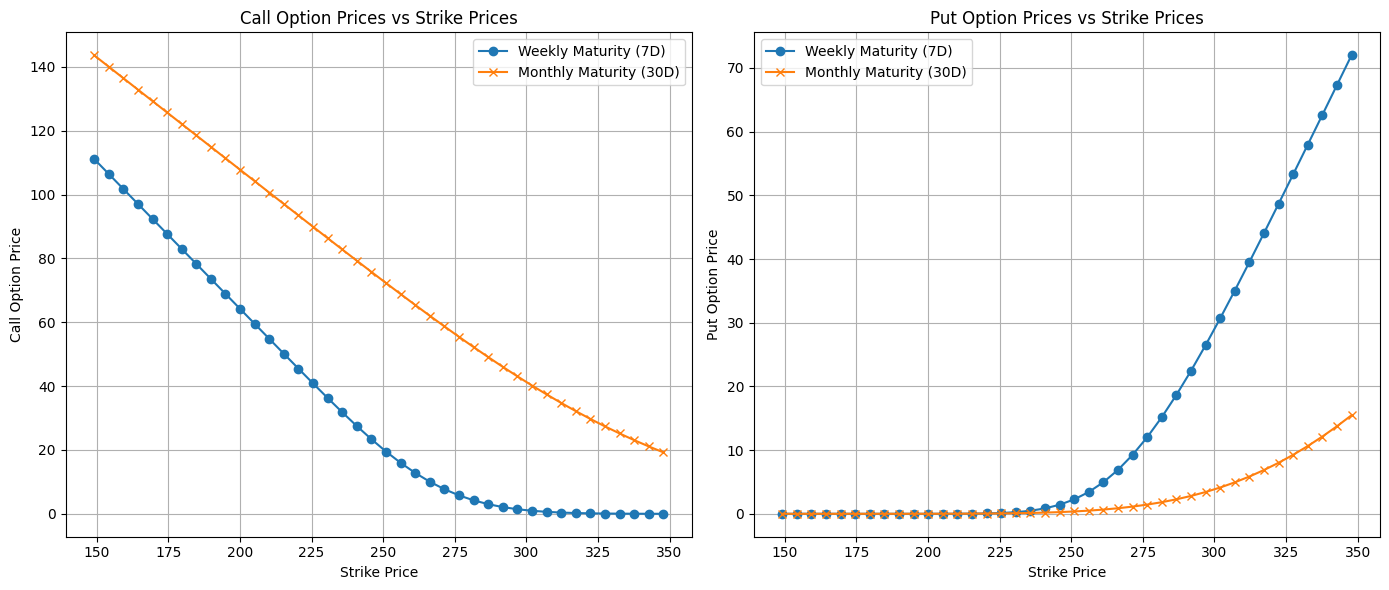

In [ ]:
tsla_data["p_date"] = pd.to_datetime(tsla_data["p_date"])
sofr_data["observation_date"] = pd.to_datetime(sofr_data["observation_date"])

#Filtering Data
tsla_data = tsla_data[(tsla_data["fsym_id"] == "Q2YN1N-R") & (tsla_data["p_date"] >= "2023-12-31") & (tsla_data["p_date"] <= "2024-12-31")].copy()

tsla_data.sort_values("p_date", inplace=True)
tsla_data["log_return"] = np.log(tsla_data["p_price"] / tsla_data["p_price"].shift(1))

#Assuming 252 trading days in a year
volatility = tsla_data["log_return"].std() * np.sqrt(252)

sofr_filtered = sofr_data[(sofr_data["observation_date"] >= "2023-12-31") & (sofr_data["observation_date"] <= "2024-12-31")]
risk_free_rate = sofr_data['SOFR'].iloc[-1]
tsla_data.head(), volatility, risk_free_rate

reference_date = pd.to_datetime("2024-01-01") #01/01 Selected as no Data Available for 31/12

#Get TSLA closing price on reference date
tsla_price_on_ref = tsla_data.loc[tsla_data["p_date"] == reference_date, "p_price"].values[0]

#Defining strike price range (10 ITM and 10 OTM each for calls and puts)
#Strike prices range from 60% to 140% of the current stock price. 
#This covers ITM options: strike < stock price and OTM options: strike > stock price 
strike_range = np.linspace(tsla_price_on_ref * 0.6, tsla_price_on_ref * 1.4, 40)
strike_prices = np.round(strike_range, 2)

days = 365
T_weekly = 7/days
T_monthly = 30/days

def black_scholes_price(S, K, T, r, sigma, option="call"):
    d1 = (np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T))
    d2 = (np.log(S/K)+(r-(sigma**2)/2)*T)/(sigma*np.sqrt(T))
    if option == "call":
        return S * norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    elif option == "put":
        return K * np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)
    else:
        raise ValueError("option must be 'call' or 'put'")

# Calculate option prices
call_prices_weekly = [black_scholes_price(tsla_price_on_ref, K, T_weekly, risk_free_rate, volatility, "call") for K in strike_prices]
call_prices_monthly = [black_scholes_price(tsla_price_on_ref, K, T_monthly, risk_free_rate, volatility, "call") for K in strike_prices]
put_prices_weekly = [black_scholes_price(tsla_price_on_ref, K, T_weekly, risk_free_rate, volatility, "put") for K in strike_prices]
put_prices_monthly = [black_scholes_price(tsla_price_on_ref, K, T_monthly, risk_free_rate, volatility, "put") for K in strike_prices]

# Plotting
plt.figure(figsize=(14, 6))

# Call Options
plt.subplot(1, 2, 1)
plt.plot(strike_prices, call_prices_weekly, label='Weekly Maturity (7D)', marker='o')
plt.plot(strike_prices, call_prices_monthly, label='Monthly Maturity (30D)', marker='x')
plt.title('Call Option Prices vs Strike Prices')
plt.xlabel('Strike Price')
plt.ylabel('Call Option Price')
plt.legend()
plt.grid(True)

# Put Options
plt.subplot(1, 2, 2)
plt.plot(strike_prices, put_prices_weekly, label='Weekly Maturity (7D)', marker='o')
plt.plot(strike_prices, put_prices_monthly, label='Monthly Maturity (30D)', marker='x')
plt.title('Put Option Prices vs Strike Prices')
plt.xlabel('Strike Price')
plt.ylabel('Put Option Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("Output_Black_Scholes.png", dpi = 500)
plt.show()
